In [1]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="uN1O0EDdiSuJbSsnD4bb")
project = rf.workspace("tpva").project("album-genre")
version = project.version(2)
dataset = version.download("folder")

loading Roboflow workspace...
loading Roboflow project...


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
from tqdm import tqdm

In [3]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
train_dir = '/content/Album-Genre-2/train'
validation_dir = '/content/Album-Genre-2/valid'
test_dir = '/content/Album-Genre-2/test'

In [5]:
# Parameters
BATCH_SIZE = 50
IMG_SIZE = 224
NUM_WORKERS = 2

In [6]:
# Transforms
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [7]:
# Datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(validation_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)


In [8]:
# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [9]:
# Class names and number of classes
class_names = train_dataset.classes
num_classes = len(class_names)
print(f"Number of classes: {num_classes}")


Number of classes: 14


In [10]:
# Define the model
class EfficientNetClassifier(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNetClassifier, self).__init__()
        self.base_model = models.efficientnet_b0(weights="IMAGENET1K_V1")
        self.base_model.classifier[1] = nn.Linear(self.base_model.classifier[1].in_features, num_classes)

    def forward(self, x):
        return self.base_model(x)

In [11]:
model = EfficientNetClassifier(num_classes).to(device)

In [12]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [13]:
# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5)

In [14]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0.0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, metric):
        if self.best_score is None or metric > self.best_score + self.delta:
            self.best_score = metric
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [15]:
# Training loop with model saving
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=1, save_interval=1, patience=3):
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    # Early stopping variables
    best_val_acc = 0.0
    early_stop_counter = 0

    for epoch in tqdm(range(num_epochs)):
        # Training
        model.train()
        running_loss, correct = 0.0, 0
        for inputs, labels in tqdm(train_loader, leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = correct / len(train_loader.dataset)
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)

        # Validation
        model.eval()
        running_loss, correct = 0.0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)
                correct += (outputs.argmax(1) == labels).sum().item()

        val_loss = running_loss / len(val_loader.dataset)
        val_acc = correct / len(val_loader.dataset)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        # Adjust learning rate
        scheduler.step(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs}: "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Save model every save_interval epochs
        if (epoch + 1) % save_interval == 0:
            model_filename = f"EfficientNet_{epoch+1}epochs_DATAAUG.pth"
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()
            }, model_filename)
            print(f"Model saved as {model_filename}")

        # Early stopping logic
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            early_stop_counter = 0  # Reset counter if improvement
        else:
            early_stop_counter += 1
            print(f"No improvement for {early_stop_counter} epoch(s).")

        if early_stop_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

    return history

In [16]:
history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20, save_interval=1, patience=3)

  5%|▌         | 1/20 [00:42<13:26, 42.47s/it]

Epoch 1/20: Train Loss: 2.3068, Train Acc: 0.2343, Val Loss: 2.7040, Val Acc: 0.1659
Model saved as EfficientNet_1epochs_DATAAUG.pth



 10%|█         | 2/20 [01:24<12:39, 42.19s/it]

Epoch 2/20: Train Loss: 1.6965, Train Acc: 0.4449, Val Loss: 3.2235, Val Acc: 0.1732
Model saved as EfficientNet_2epochs_DATAAUG.pth



 15%|█▌        | 3/20 [02:07<12:01, 42.43s/it]

Epoch 3/20: Train Loss: 1.0420, Train Acc: 0.6651, Val Loss: 4.0684, Val Acc: 0.1426
Model saved as EfficientNet_3epochs_DATAAUG.pth
No improvement for 1 epoch(s).



 20%|██        | 4/20 [02:49<11:16, 42.28s/it]

Epoch 4/20: Train Loss: 0.6020, Train Acc: 0.8060, Val Loss: 4.4130, Val Acc: 0.1689
Model saved as EfficientNet_4epochs_DATAAUG.pth
No improvement for 2 epoch(s).



 20%|██        | 4/20 [03:31<14:06, 52.90s/it]

Epoch 5/20: Train Loss: 0.3894, Train Acc: 0.8722, Val Loss: 4.9948, Val Acc: 0.1557
Model saved as EfficientNet_5epochs_DATAAUG.pth
No improvement for 3 epoch(s).
Early stopping triggered after 5 epochs.


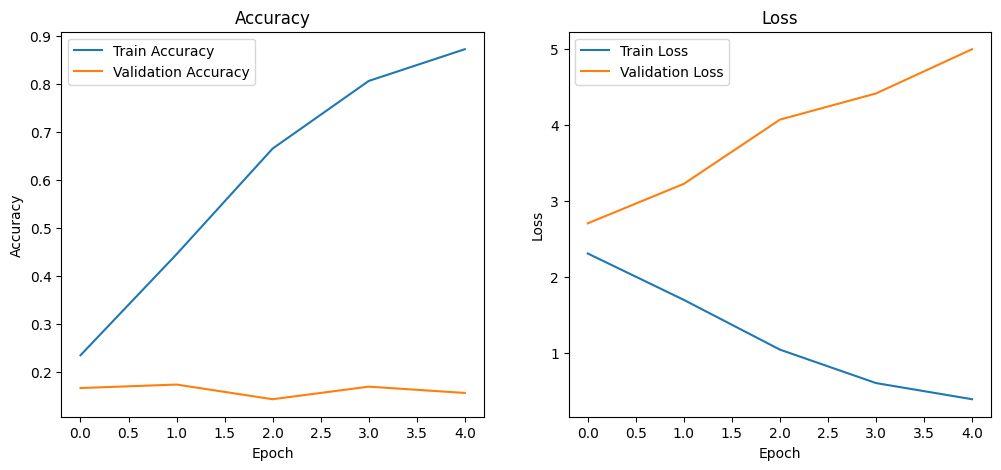

In [17]:
# Plot accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history["train_acc"], label="Train Accuracy")
plt.plot(history["val_acc"], label="Validation Accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

F1 Score: 0.9580
              precision    recall  f1-score   support

      class1       0.98      0.91      0.94      1029
     class11       0.98      0.98      0.98       906
     class12       0.97      0.94      0.96      1062
     class13       0.94      0.98      0.96       363
     class14       0.96      0.97      0.96       774
     class15       0.95      0.93      0.94       411
      class2       0.96      0.96      0.96      1071
      class3       0.94      0.97      0.95       330
      class4       0.98      0.98      0.98       501
      class5       0.98      0.96      0.97       963
      class6       0.93      0.97      0.95       411
      class7       0.94      0.99      0.96       411
      class8       0.98      0.99      0.98       357
      class9       0.91      0.97      0.94      1041

    accuracy                           0.96      9630
   macro avg       0.96      0.96      0.96      9630
weighted avg       0.96      0.96      0.96      9630



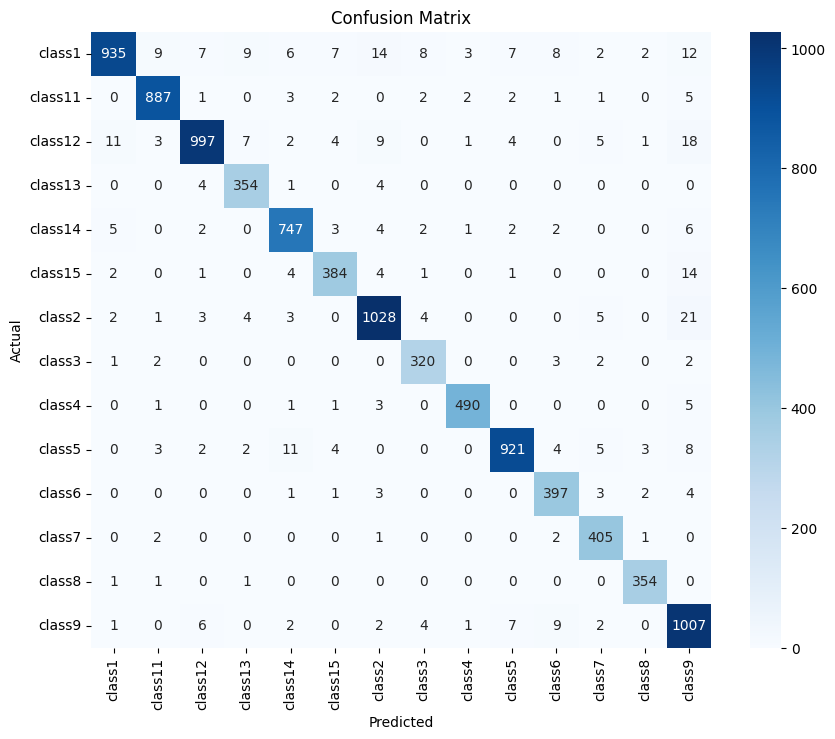

In [18]:
#ACC Y CONF MAT DE TRAIN
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        all_preds.append(outputs.argmax(1).cpu().numpy())
        all_labels.append(labels.cpu().numpy())

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)


f1 = f1_score(all_labels, all_preds, average='weighted')
print(f"F1 Score: {f1:.4f}")
print(classification_report(all_labels, all_preds, target_names=class_names))


conf_mat = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


F1 Score: 0.1583
              precision    recall  f1-score   support

      class1       0.19      0.14      0.16        76
     class11       0.30      0.26      0.28        62
     class12       0.14      0.09      0.11        77
     class13       0.10      0.12      0.11        25
     class14       0.10      0.12      0.11        56
     class15       0.16      0.19      0.18        26
      class2       0.09      0.11      0.10        66
      class3       0.07      0.12      0.09        17
      class4       0.31      0.26      0.28        43
      class5       0.16      0.13      0.15        75
      class6       0.03      0.04      0.04        26
      class7       0.20      0.14      0.16        36
      class8       0.11      0.17      0.13        23
      class9       0.18      0.23      0.20        79

    accuracy                           0.16       687
   macro avg       0.15      0.15      0.15       687
weighted avg       0.17      0.16      0.16       687



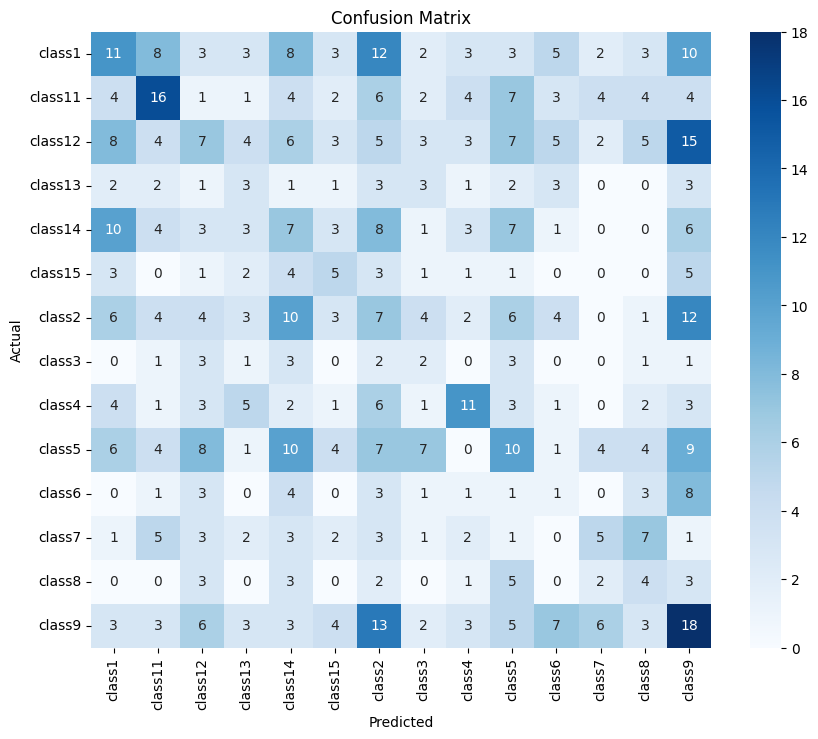

In [19]:
#ACC Y CONF MAT DE VAL
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        all_preds.append(outputs.argmax(1).cpu().numpy())
        all_labels.append(labels.cpu().numpy())

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)


f1 = f1_score(all_labels, all_preds, average='weighted')
print(f"F1 Score: {f1:.4f}")
print(classification_report(all_labels, all_preds, target_names=class_names))


conf_mat = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


F1 Score: 0.1662
              precision    recall  f1-score   support

      class1       0.22      0.19      0.20        80
     class11       0.20      0.21      0.21        66
     class12       0.11      0.09      0.10        69
     class13       0.14      0.22      0.17        27
     class14       0.16      0.21      0.18        47
     class15       0.06      0.08      0.07        26
      class2       0.20      0.17      0.18        77
      class3       0.13      0.12      0.13        24
      class4       0.35      0.18      0.24        39
      class5       0.22      0.17      0.19        83
      class6       0.17      0.23      0.19        31
      class7       0.12      0.10      0.11        29
      class8       0.07      0.12      0.09        16
      class9       0.12      0.15      0.13        74

    accuracy                           0.16       688
   macro avg       0.16      0.16      0.16       688
weighted avg       0.18      0.16      0.17       688



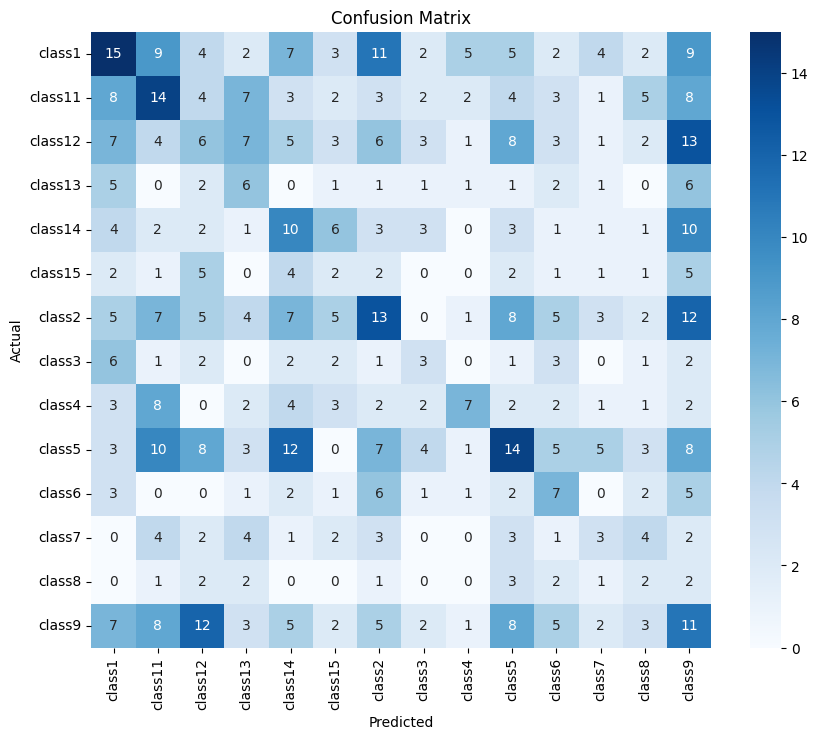

In [20]:
#ACC Y CONF MAT DE TEST
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        all_preds.append(outputs.argmax(1).cpu().numpy())
        all_labels.append(labels.cpu().numpy())

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)


f1 = f1_score(all_labels, all_preds, average='weighted')
print(f"F1 Score: {f1:.4f}")
print(classification_report(all_labels, all_preds, target_names=class_names))


conf_mat = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()